In [1]:
import sys
sys.path.append('/home/npopkov/dll24')

import matplotlib.pyplot as plt
import torch
torch.backends.cudnn.benchmark = True

import numpy as np
import lightning as lt
torch.set_float32_matmul_precision('medium')
import soundfile as sf

from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler

from torch.utils.data import DataLoader,Dataset

import h5py
from tqdm.auto import tqdm

class SnippetDatasetHDF(Dataset):
    def __init__(self, hdf, scaling='minmax'):
        self.num_rows = 0
        self.size = 2**15
        self.data = self.createData(hdf)
        
        if scaling == 'standard':
            self.mean = np.mean(self.data)
            self.std =  np.std(self.data)
            self.data = (self.data - self.mean) / self.std
        
        if scaling == 'minmax':
            self.min = self.data.min()
            self.max = self.data.max()
            self.data = (self.data - self.min) / (self.max - self.min)
    
    def __len__(self):
        return self.num_rows
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def createData(self, hdf):
        data = []
        keys = list(hdf.keys())
        self.num_rows = len(keys)
        for key in tqdm(keys):
            sample = hdf[key]['audio'][:]
            if len(sample) > self.size:
                self.num_rows -= 1
                continue

            if len(sample) < self.size:
                sample = np.pad(sample, (0, self.size - len(sample)), 'constant')

            data.append(sample)
         
        return torch.tensor(np.array(data)).float()


hdf = h5py.File('../test.hdf5', 'r')
dataset = SnippetDatasetHDF(hdf)
hdf.close()



  0%|          | 0/2504 [00:00<?, ?it/s]

In [2]:
from models.AEA.AEA import AEA

autoencoder = AEA(1)



In [3]:
 

dataloader = DataLoader(dataset, batch_size=32,num_workers=30)
# Train model with audio waveforms
trainer = lt.Trainer(max_epochs=50)
trainer.fit(autoencoder, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/npopkov/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-08-07 11:22:35.571820: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 11:22:35.579079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 11:22:35.585416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [9]:
from IPython.display import Audio
samplerate = 32000
real_sample = dataset.data[0] * (dataset.max - dataset.min) + dataset.min
Audio(real_sample, rate=samplerate)

In [10]:
# Turn noise into new audio sample with diffusion
latent = autoencoder.encoder(dataset.data[0].unsqueeze(0).unsqueeze(0))
pred = autoencoder.decoder(latent)
retransformed_pred = (pred * (dataset.max - dataset.min) + dataset.min).detach().numpy()
Audio(retransformed_pred[0,0], rate=samplerate)

In [6]:
print(dataset.data[1].shape,
latent.shape)

torch.Size([32768]) torch.Size([1, 256, 2047])


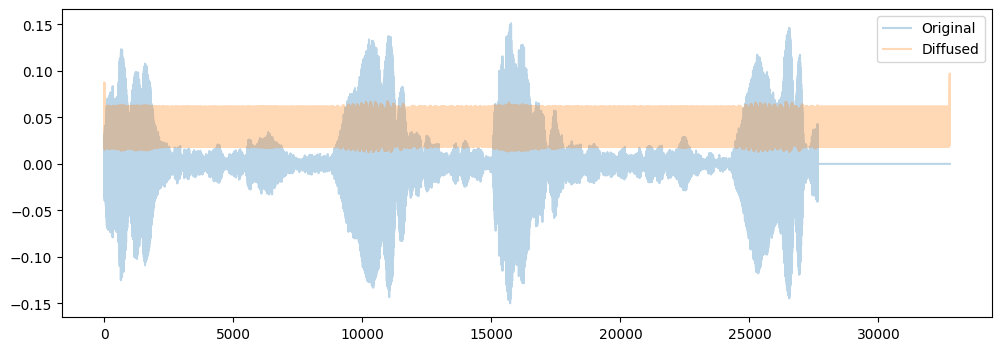

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(real_sample.cpu().numpy(), alpha=0.3, label='Original')
plt.plot(retransformed_pred[0, 0], alpha=0.3, label='Diffused')
plt.legend()

In [8]:
from IPython.display import Audio
Audio(retransformed_pred[0,0], rate=samplerate)
